Load env

In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


In [2]:
from dotenv import load_dotenv, find_dotenv
# set api key
_ = load_dotenv(find_dotenv()) # read local .env file

Setup LLM

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    temperature=0.,  # Điều chỉnh độ sáng tạo của model
    max_tokens=512,   # Giới hạn số token đầu ra        
)

# Building Blocks: The Augmented LLM

In [4]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
output


SearchQuery(search_query='Calcium CT score and high cholesterol relationship', justification='This query aims to find information on how calcium CT scores, which measure coronary artery calcification, relate to high cholesterol levels, as both are important factors in assessing cardiovascular health.')

In [5]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_ga6F8Cxa8oyAEagHttHTmoJt',
  'type': 'tool_call'}]

# Prompt chaining

Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

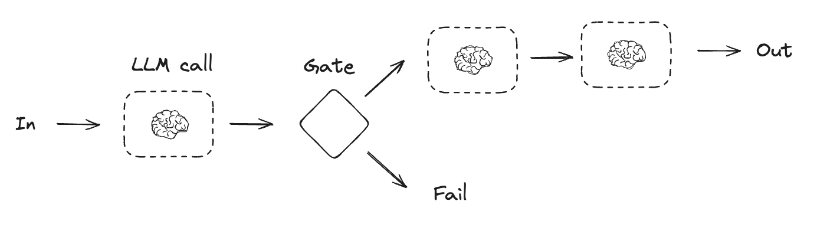

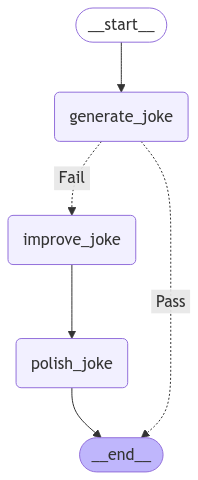

In [6]:


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [7]:
# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why was the cat sitting on the computer? 

Because it wanted to keep an eye on the mouse!

--- --- ---

Improved joke:
Why was the cat sitting on the computer? 

Because it wanted to keep an eye on the mouse and make sure it didn’t click away!

--- --- ---

Final joke:
Why was the cat sitting on the computer? 

Because it wanted to keep an eye on the mouse and make sure it didn’t click away! But little did it know, the mouse was actually a secret agent, and the cat was about to become the unwitting sidekick in a high-stakes cyber heist!


# Parallelization

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

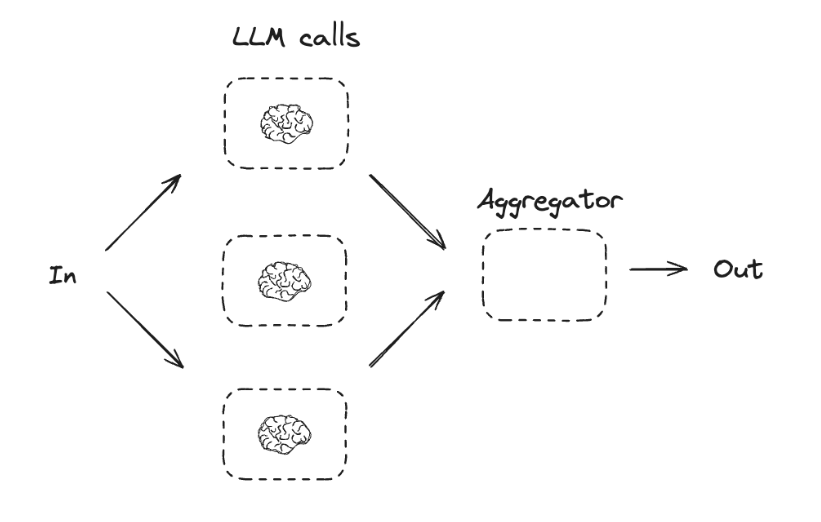

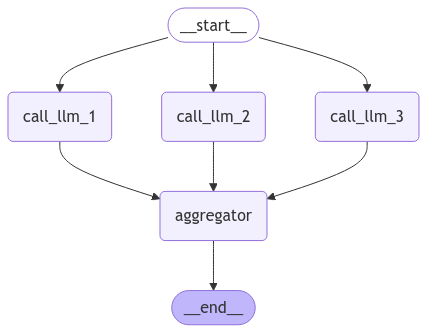

Here's a story, joke, and poem about cats!

STORY:
Once upon a time in a quaint little village nestled between rolling hills, there was a charming little shop called "Whiskers & Wonders." The shop was owned by an elderly woman named Mrs. Hargrove, who had a special affinity for cats. Her shop was filled with all sorts of trinkets, toys, and treats for feline friends, but what made it truly unique was the collection of cats that roamed freely throughout the store.

Mrs. Hargrove had a dozen cats, each with its own distinct personality. There was Oliver, the wise old tabby who loved to perch on the highest shelf and observe the world below; Luna, the playful calico who would chase after anything that moved; and Jasper, the aloof Siamese who preferred to watch from a distance, his piercing blue eyes taking in everything with a hint of disdain.

One sunny afternoon, as the village prepared for its annual Harvest Festival, a commotion erupted in the shop. Luna had discovered a small, shimme

In [8]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

# Routing

Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.|

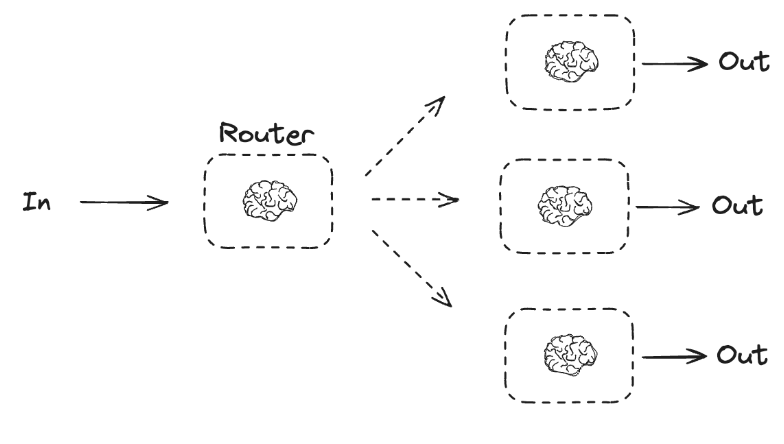

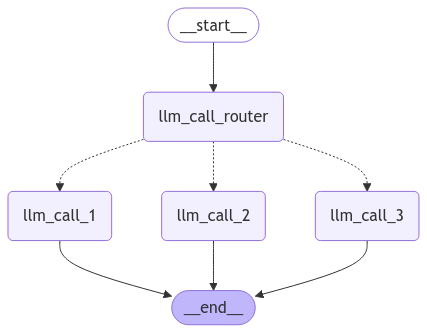

In [9]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))



In [10]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!


# AGENT


Agents can handle sophisticated tasks, but their implementation is often straightforward. They are typically just LLMs using tools based on environmental feedback in a loop. It is therefore crucial to design toolsets and their documentation clearly and thoughtfully.

When to use agents: Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments.

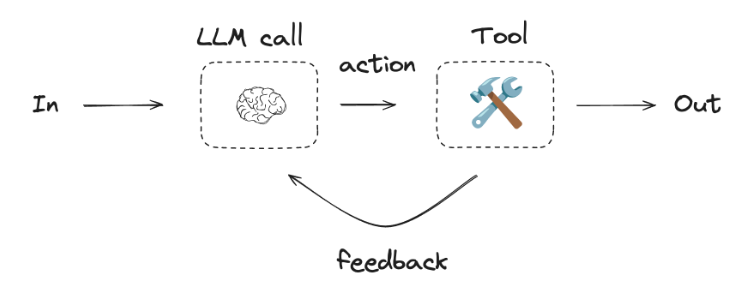

In [4]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [9]:
from typing import Literal


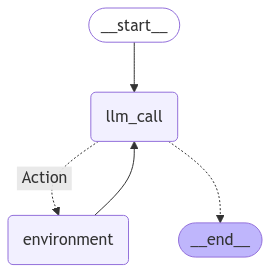

In [10]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))



In [14]:
# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
# for m in messages["messages"]:
#     m.pretty_print()
messages

{'messages': [HumanMessage(content='Add 3 and 4.', additional_kwargs={}, response_metadata={}, id='19aa810b-fa8d-4d7e-acd4-0e8da6544438'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3CzVSiemgqvnnEHCo9tns35Q', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 150, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d34d5581-43f6-4621-baa9-c5308d174a90-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_3CzVSiemgqvnnEHCo9tns35Q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 150, 'output_tokens': 18, 'to

In [19]:
messages.get("messages")[-1].content

'The sum of 3 and 4 is 7.'